In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# 필요한 라이브러리 임포트
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import random
from sklearn.model_selection import KFold

# 다시 임포트
from models_jh import CNN
from Segdataset_jh import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [3]:
print(CNN)

<class 'models_jh.CNN'>


In [4]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/CREMA-D/train'
        self.save_root = '/workspace/UndergraduateResearchAssistant/GraduateProject/code/CREMA-D/checkpoints_jh'
        self.epoch = 200
        self.lr = 1e-5
        self.batch_size = 64
        self.num_workers = 16
        self.random_seed = 1
        self.n_mfcc = 20
        self.n_splits = 5

opt = Args()


In [5]:
def main():
    print("Training by CNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [6]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = CNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.45).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [7]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by CNN
Using device: cuda
Fold 1/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 1 | Epoch 0 | Train Loss: 0.4385036938899272 | Val Loss: 0.4351509428686566 | Val Accuracy: 0.6779513888888888
Fold 1 | Epoch 1 | Train Loss: 0.431377387932829 | Val Loss: 0.4305069512791104 | Val Accuracy: 0.6701388888888888
Fold 1 | Epoch 2 | Train Loss: 0.42646538929359334 | Val Loss: 0.42695706917179954 | Val Accuracy: 0.6692708333333334
Fold 1 | Epoch 3 | Train Loss: 0.4228969176073332 | Val Loss: 0.42365243865383995 | Val Accuracy: 0.6684027777777778
Fold 1 | Epoch 4 | Train Loss: 0.41921889500038045 | Val Loss: 0.4205879353814655 | Val Accuracy: 0.6675347222222222
Fold 1 | Epoch 5 | Train Loss: 0.4160344000603702 | Val Loss: 0.4175917837354872 | Val Accuracy: 0.6710069444444444
Fold 1 | Epoch 6 | Train Loss: 0.41312064230442047 | Val Loss: 0.4145605249537362 | Val Accuracy: 0.6727430555555556
Fold 1 | Epoch 7 | Train Loss: 0.4099008251686354 | Val Loss: 0.41142774

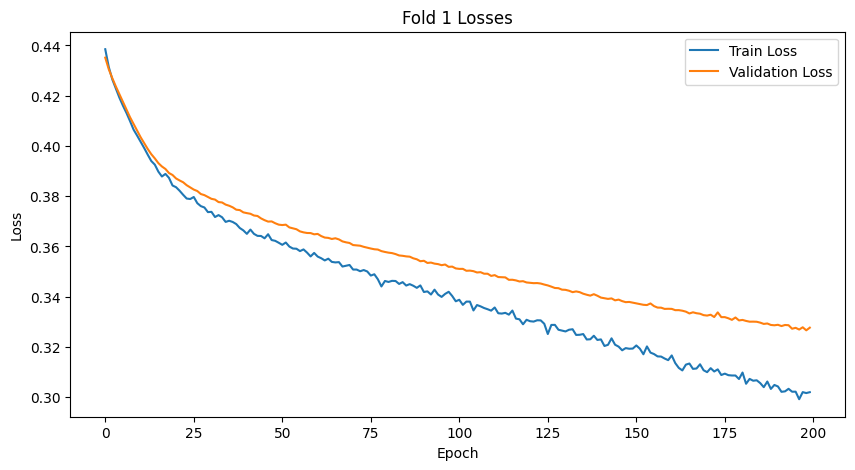

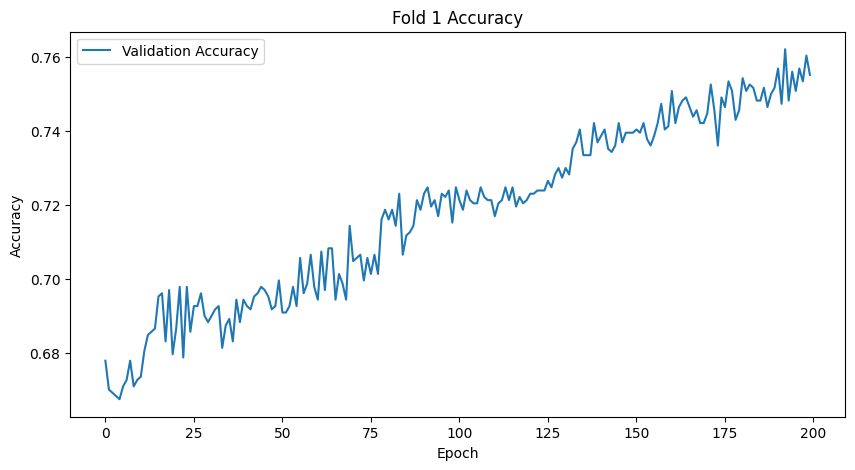

Fold 2/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 2 | Epoch 0 | Train Loss: 0.4367767407281979 | Val Loss: 0.4308599399195777 | Val Accuracy: 0.6970486111111112
Fold 2 | Epoch 1 | Train Loss: 0.4316651603660068 | Val Loss: 0.42392562826474506 | Val Accuracy: 0.7048611111111112
Fold 2 | Epoch 2 | Train Loss: 0.4276826925374366 | Val Loss: 0.4178273065222634 | Val Accuracy: 0.7083333333333334
Fold 2 | Epoch 3 | Train Loss: 0.4234625737409334 | Val Loss: 0.41361355947123635 | Val Accuracy: 0.7118055555555556
Fold 2 | Epoch 4 | Train Loss: 0.4200813564899805 | Val Loss: 0.4085120310386022 | Val Accuracy: 0.7118055555555556
Fold 2 | Epoch 5 | Train Loss: 0.4163665803703102 | Val Loss: 0.40400541987684035 | Val Accuracy: 0.7109375
Fold 2 | Epoch 6 | Train Loss: 0.4127595009835991 | Val Loss: 0.39975659880373215 | Val Accuracy: 0.7109375
Fold 2 | Epoch 7 | Train Loss: 0.40957411237665126 | Val Loss: 0.3958739952908622 | Val Accuracy: 0.7118055555555556
Fold 2 |

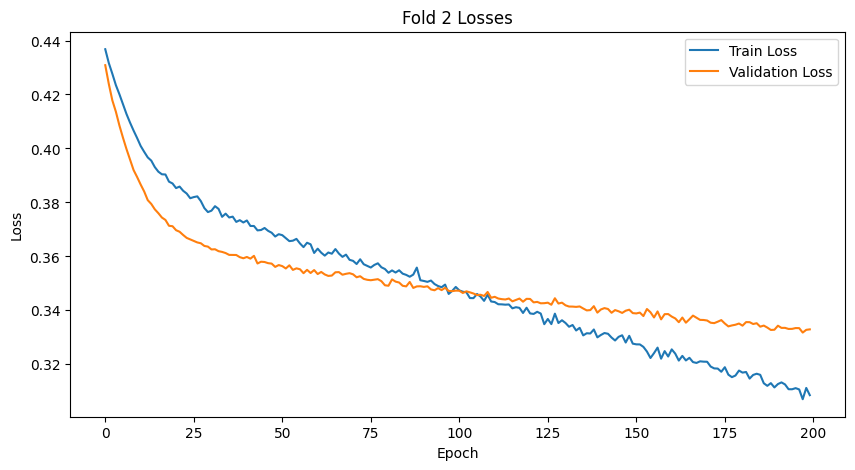

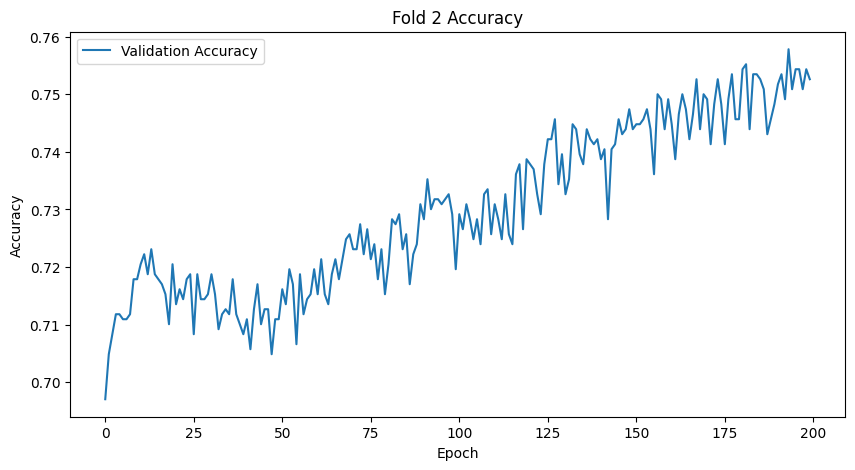

Fold 3/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 3 | Epoch 0 | Train Loss: 0.43562365303168427 | Val Loss: 0.4374835309055116 | Val Accuracy: 0.6510416666666666
Fold 3 | Epoch 1 | Train Loss: 0.4305511958695747 | Val Loss: 0.43312938180234695 | Val Accuracy: 0.6605902777777778
Fold 3 | Epoch 2 | Train Loss: 0.42597587487182104 | Val Loss: 0.4291182474957572 | Val Accuracy: 0.6666666666666666
Fold 3 | Epoch 3 | Train Loss: 0.42229472825656067 | Val Loss: 0.4255122211244371 | Val Accuracy: 0.6657986111111112
Fold 3 | Epoch 4 | Train Loss: 0.4184171364114091 | Val Loss: 0.422105653418435 | Val Accuracy: 0.6684027777777778
Fold 3 | Epoch 5 | Train Loss: 0.4153336214052664 | Val Loss: 0.4188924680153529 | Val Accuracy: 0.6684027777777778
Fold 3 | Epoch 6 | Train Loss: 0.4113015838571497 | Val Loss: 0.4157843010293113 | Val Accuracy: 0.6744791666666666
Fold 3 | Epoch 7 | Train Loss: 0.40920989134827174 | Val Loss: 0.41301605933242375 | Val Accuracy: 0.6762152

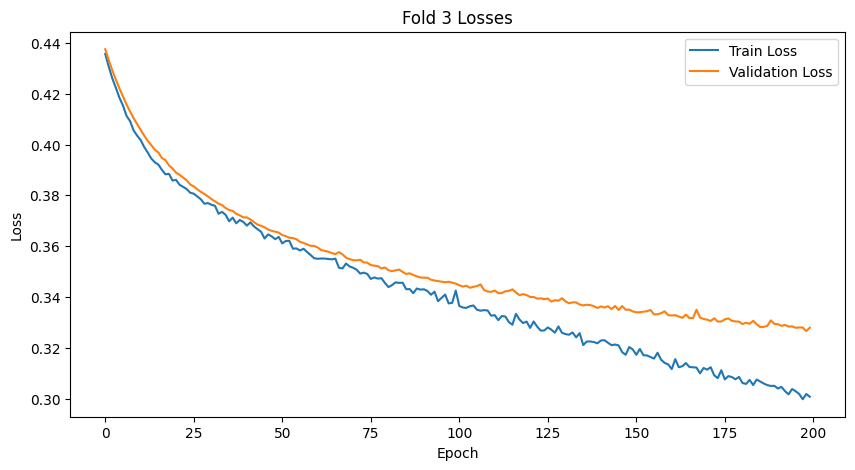

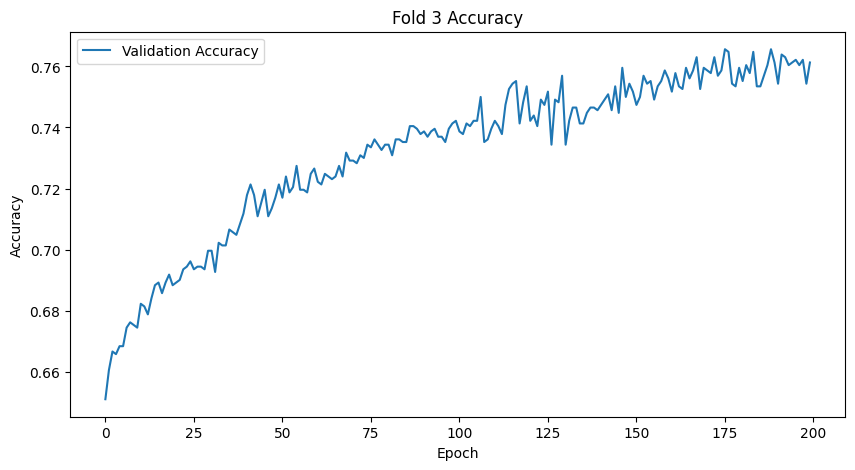

Fold 4/5
Dataset loaded with 4763 samples.
Dataset loaded with 1190 samples.
Fold 4 | Epoch 0 | Train Loss: 0.4312207336361344 | Val Loss: 0.4304121765825484 | Val Accuracy: 0.6666666666666666
Fold 4 | Epoch 1 | Train Loss: 0.42596920237347885 | Val Loss: 0.4268321130010817 | Val Accuracy: 0.6640625
Fold 4 | Epoch 2 | Train Loss: 0.422406825262147 | Val Loss: 0.42405830489264595 | Val Accuracy: 0.6675347222222222
Fold 4 | Epoch 3 | Train Loss: 0.41935781127697713 | Val Loss: 0.42154308822419906 | Val Accuracy: 0.6657986111111112
Fold 4 | Epoch 4 | Train Loss: 0.4161783307790756 | Val Loss: 0.41926326519913143 | Val Accuracy: 0.6692708333333334
Fold 4 | Epoch 5 | Train Loss: 0.41294801919846924 | Val Loss: 0.41687734921773273 | Val Accuracy: 0.6692708333333334
Fold 4 | Epoch 6 | Train Loss: 0.41146181362706263 | Val Loss: 0.41475166214836967 | Val Accuracy: 0.6675347222222222
Fold 4 | Epoch 7 | Train Loss: 0.40876767925314 | Val Loss: 0.41286569833755493 | Val Accuracy: 0.65972222222222

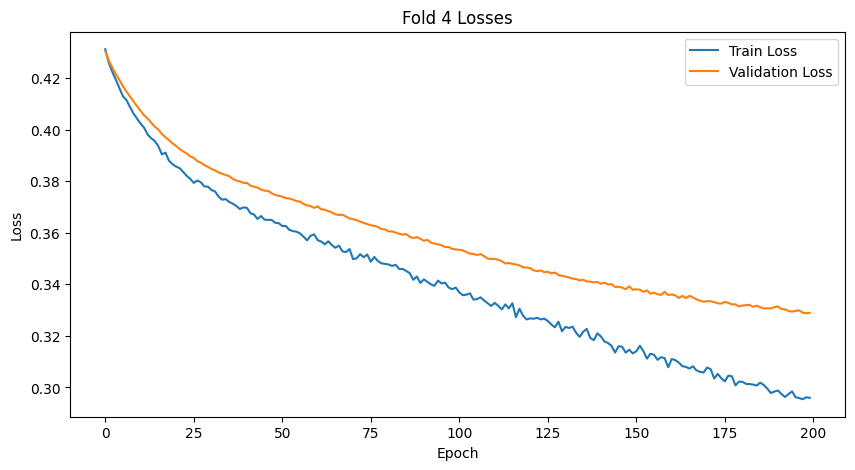

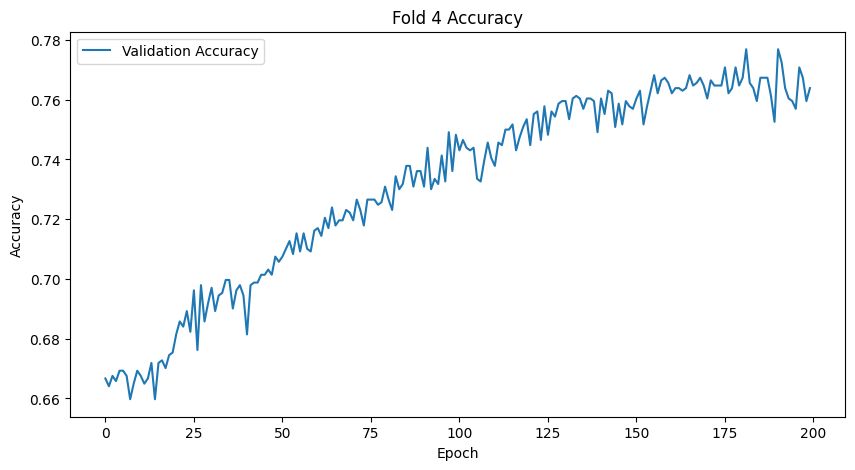

Fold 5/5
Dataset loaded with 4763 samples.
Dataset loaded with 1190 samples.
Fold 5 | Epoch 0 | Train Loss: 0.43754858624290777 | Val Loss: 0.43337616324424744 | Val Accuracy: 0.6796875
Fold 5 | Epoch 1 | Train Loss: 0.43147869931684957 | Val Loss: 0.42951293455229866 | Val Accuracy: 0.6822916666666666
Fold 5 | Epoch 2 | Train Loss: 0.4273446093539934 | Val Loss: 0.42631463209788006 | Val Accuracy: 0.6805555555555556
Fold 5 | Epoch 3 | Train Loss: 0.42321213999310053 | Val Loss: 0.4233638362752067 | Val Accuracy: 0.6753472222222222
Fold 5 | Epoch 4 | Train Loss: 0.4194009573878469 | Val Loss: 0.4203423659006755 | Val Accuracy: 0.6770833333333334
Fold 5 | Epoch 5 | Train Loss: 0.41670458824247925 | Val Loss: 0.4175388332870271 | Val Accuracy: 0.6710069444444444
Fold 5 | Epoch 6 | Train Loss: 0.41286699272490834 | Val Loss: 0.414754933781094 | Val Accuracy: 0.6675347222222222
Fold 5 | Epoch 7 | Train Loss: 0.4098262472732647 | Val Loss: 0.4122238473759757 | Val Accuracy: 0.66840277777777

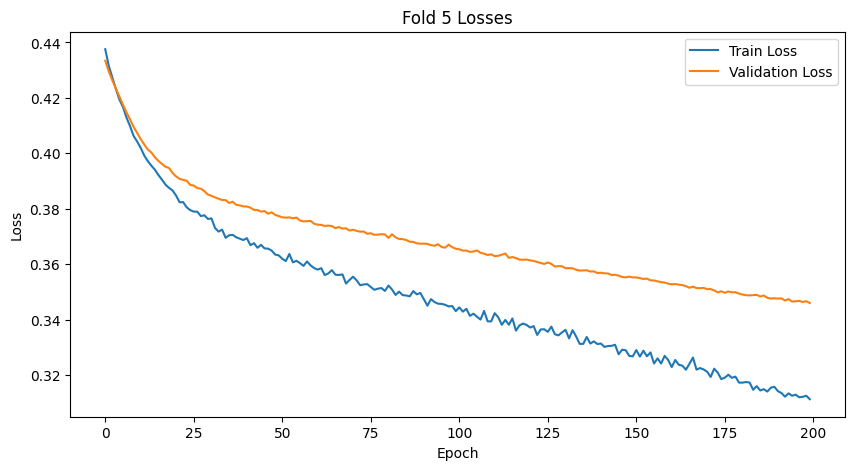

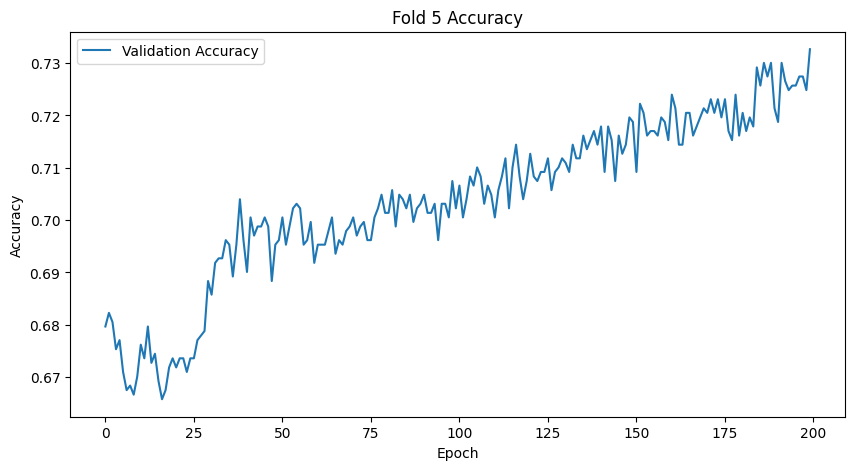

In [8]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)